In [1]:
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

from made.can import CAN
from made.utils import simulate_many_with_initial_states
from made.visuals import clean_axes

# Set parameters

In [2]:
TOPOLOGY = 'Plane'  # change the manifold topology
N_SAMPLES = 25  # increase this for more dense sampling
N_SIMULATION_STEPS = 25


pads = dict(Plane=[0.1, 0.1], Torus=[0, 0])
PAD = pads[TOPOLOGY]


## Simulations
Create a CAN with the desired topology, sample some points over the parameter sspace and run simulations with 
activity bumps at these points. We run multiple simulations in parallel to speed up the process. 


2025-01-20 14:11:23.145 | INFO     | __main__:<module>:5 - Samples shape: (625, 2) - values range from 0.1 to 0.9


CAN(manifold=Plane(dim=2, parameter_space=ParameterSpace(ranges=[Range(start=0, end=1, periodic=False), Range(start=0, end=1, periodic=False)]), metric=<made.metrics.Euclidean object at 0x000001642EBCAB30>), N=48, alpha=1, sigma=0.25, tau=1.5)


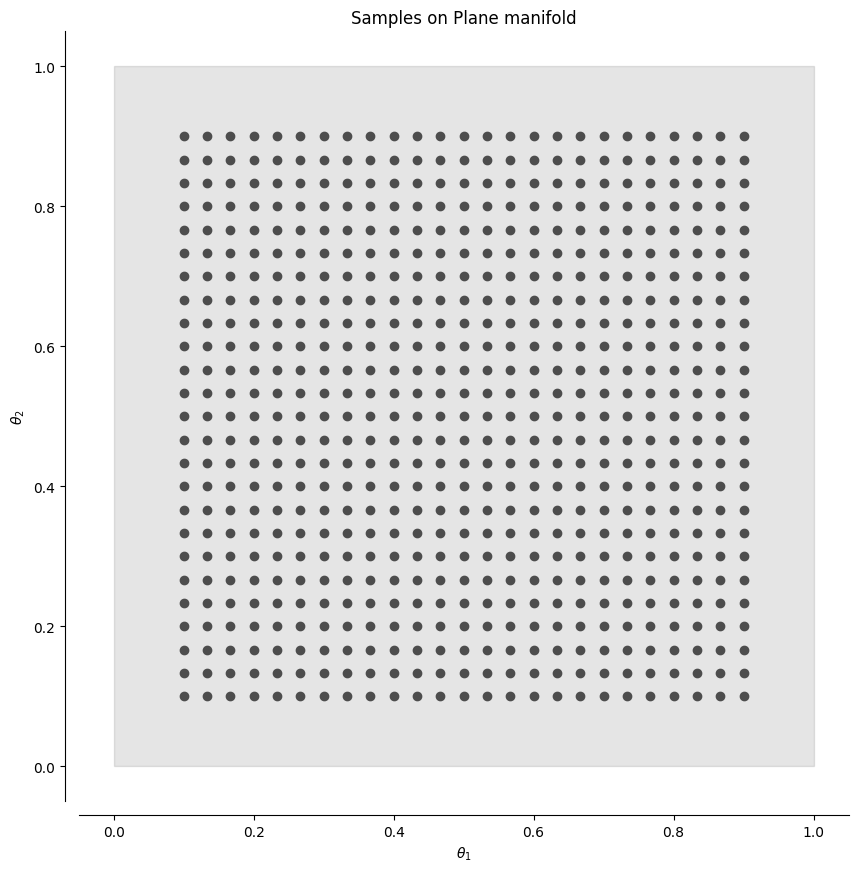

In [3]:
can = CAN.default(topology=TOPOLOGY)
print(can)

samples = can.manifold.parameter_space.sample(N_SAMPLES, pads=PAD)
logger.info(f'Samples shape: {samples.shape} - values range from {samples.min()} to {samples.max()}')

f, ax = plt.subplots(1, 1, figsize=(10, 10))
can.manifold.visualize(ax)
ax.scatter(samples[:, 0], samples[:, 1], color=[.3, .3, .3])

clean_axes(ax, title=f"Samples on {TOPOLOGY} manifold")
plt.show()



In [4]:
final_states = simulate_many_with_initial_states(can, samples, N_SIMULATION_STEPS)
logger.info(f'Matrix of final states has shape: {final_states.shape}')


2025-01-20 14:11:50.078 | INFO     | __main__:<module>:2 - Matrix of final states has shape: (625, 2304)


## Visualization
First, we take each final state and plot the position of the maximum activity in the lattice (the bump position).
This way we can see what the distribution of bumps looks like in the parameter space. 


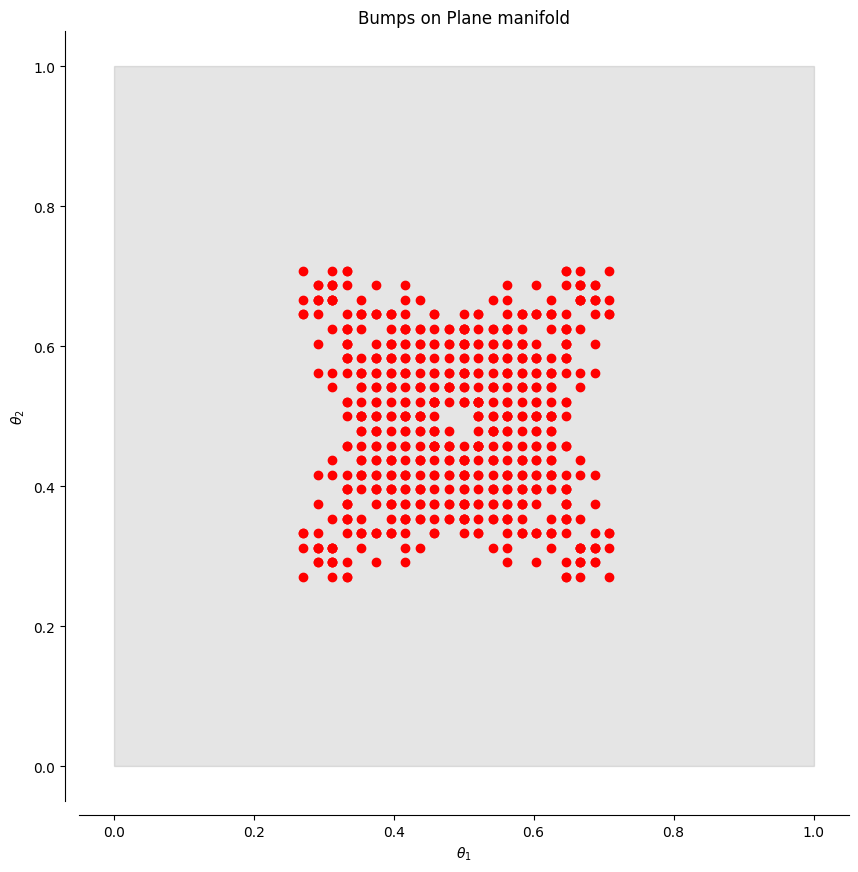

In [5]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))

can.manifold.visualize(ax)

for idx in range(0, len(final_states), 1):
    state = final_states[idx].reshape(48, 48)
    # get coords of max value
    x, y = np.unravel_index(np.argmax(state), state.shape)
    x = can.idx2coord(x, 0)
    y = can.idx2coord(y, 1)
    ax.scatter(x, y, color='red')

clean_axes(ax, title=f"Bumps on {TOPOLOGY} manifold")
plt.show()



Then, we use PCA and Isomap to reduce the dimensionality of the final states to 3 so taht we can visualize them. This shows us the topology of the activity manifold in state space. 

(625, 20)
(625, 3)


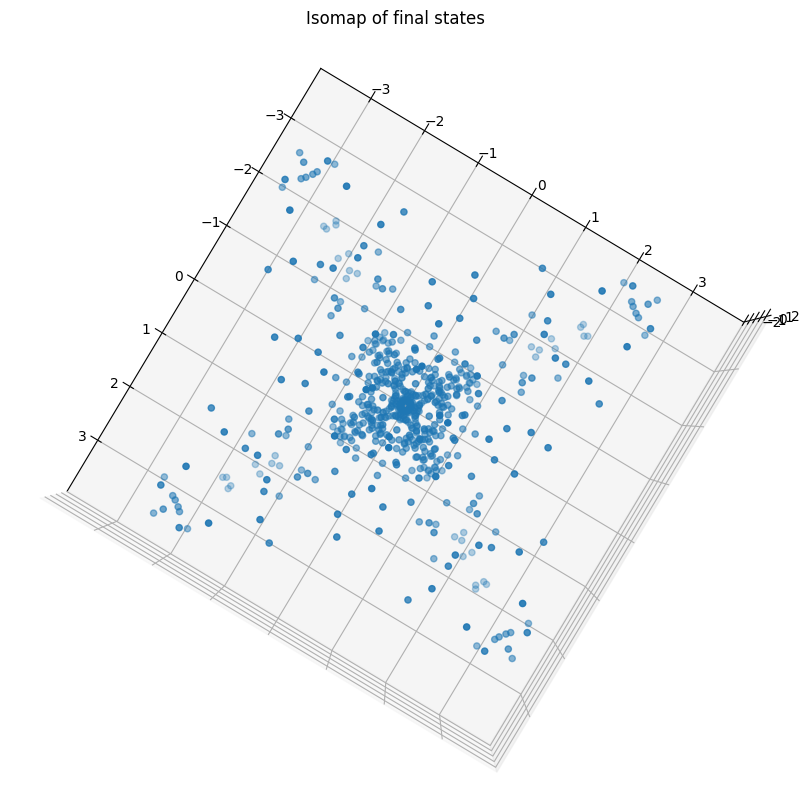

In [7]:
# fit PCA to reduce to 3 dimensions and visualize
pca = PCA(n_components=20,)
final_states_pca = pca.fit_transform(final_states)

# now to isomap
isomap = Isomap(n_components=3, n_neighbors=11)
final_states_isomap = isomap.fit_transform(final_states)

# visualize as 3D scatter
f = plt.figure(figsize=(10, 10))
ax = f.add_subplot(111, projection='3d')
ax.scatter(final_states_isomap[:, 0], final_states_isomap[:, 1], final_states_isomap[:, 2])
ax.set_title('Isomap of final states')
ax.set_aspect('equal')

ax.view_init(elev=90, azim=30)
plt.show()

